In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 1
%aimport joint_proba

In [2]:
font_size = 12
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

In [3]:
import pickle
# df = pd.read_csv('../datasets/D.txt', sep=';', index_col=0, parse_dates=True)
with open('../datasets/D.pkl', 'rb') as f:
    df = pickle.load(f)
df.head(2)

,wind speed (m/s),significant wave height (m)
time (YYYY-MM-DD-HH),,
1965-01-01 00:00:00,15.3839,3.9879
1965-01-01 01:00:00,15.4990,4.0086


In [12]:
self = joint_proba.Multivariate(df, condY_x=np.arange(1, 22))
self.fit()
# self.plot_diagnosis()

Fitting marginal X
Fitting marginal Y
Fitting discrete conditional Y
Fitting continuous conditional Y using bulk


In [49]:
[item for item in dir(self) if not item.startswith('__')]

['_get_condY_F',
 '_get_condY_para_bulk',
 '_get_jaggaed_contour',
 '_get_smooth_contour',
 'condY_cont_dists_bulk',
 'condY_disc_dists',
 'condY_x',
 'dist_cands',
 'fit',
 'plot_diagnosis',
 'predict',
 'x_data',
 'x_dist',
 'y_data',
 'y_dist']

## Predict method

In [13]:
mrp = 50

# MRP of independent Y for validation
y_mrp = self.y_dist.predict(mrp=mrp)

# Jagged contour
contour_jag = self._get_jaggaed_contour(mrp)

# Smooth contour
# Method 1: Using bulk fitting
contours_bulk = [
    self._get_smooth_contour(condY, mrp)
    for condY in self.condY_cont_dists_bulk
]
# Method 2: Using tail re-para
# condY using re-para
# df = get_condY_para_tail()
# condY_cont_dists_tail = []
# for idx in range(len(df)):
#     condY = _CondY(
#         dist_name=df.index[idx], x=self.condY_x, 
#         params=df['param'][idx], dist_config=dist_config[df.index[idx]])
#     condY.fit()
#     condY_cont_dists_tail.append(condY)
# contours_tail = [
#     get_smooth_contour(condY, condY_F)
#     for condY in condY_cont_dists_tail
# ]

# Combine result

In [ ]:
def _get_condY_para_tail(self, mrp, dist_config):
    # Determine range of re-parameterization
    
    df_temp = pd.DataFrame()
    for condY_pd in self.condY_disc_pds:
        data = condY_pd.data
        df_cur = Univariate.best_fit(
            data, dist_names=dist_names, dist_config=dist_config)
        df_temp = pd.concat([df_temp, df_cur.set_index('Distribution')], axis=1)

    # Arrange condY fitting results
    # chi_square, r2: mean
    # param: stack for different condY_x
    df = pd.concat(
        [
            df_temp['chi_square'].mean(axis=1, skipna=False),
            df_temp['r2'].mean(axis=1, skipna=False),
            df_temp['param'].apply(np.vstack, axis=1),
        ], axis=1
    ).rename(
        columns={0:'chi_square', 1:'r2', 2:'param'}
    ).sort_values(by='chi_square')

    # Select candidates based on chi_square
    df = df[df['chi_square'] < df['chi_square'][0] * 2]
    return df

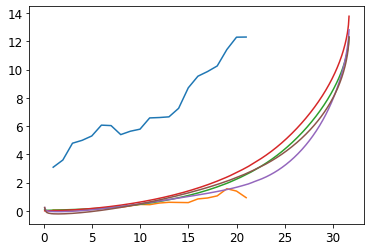

In [15]:
plt.plot(contour_jag['x'], contour_jag['y_top'])
plt.plot(contour_jag['x'], contour_jag['y_bot'])
for contour in contours_bulk:
    h = plt.plot(contour['x'], contour['y_bot'])
#     plt.plot(self.x_pd.sample_coor, contour['contour_top'], h[0].get_color())
plt.show()

## Archive

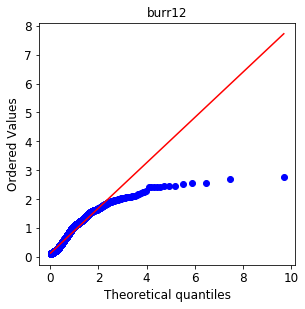

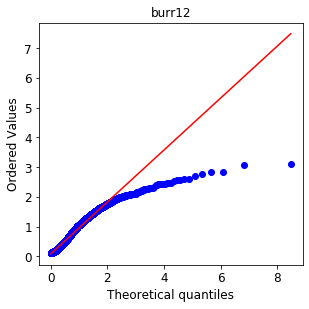

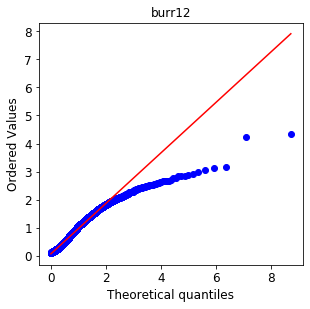

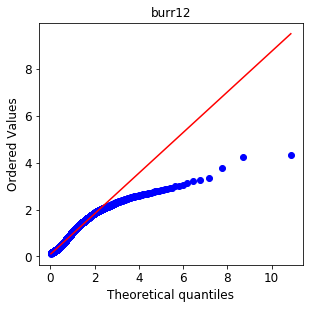

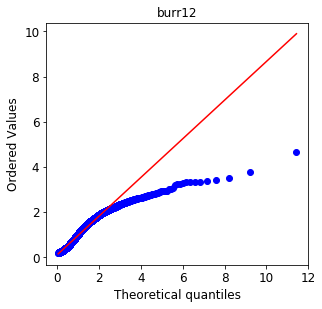

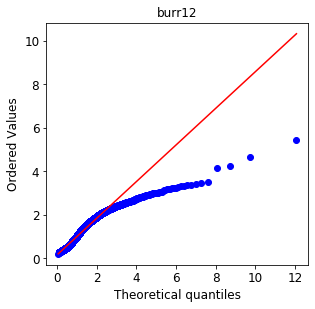

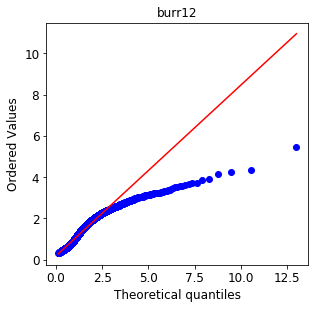

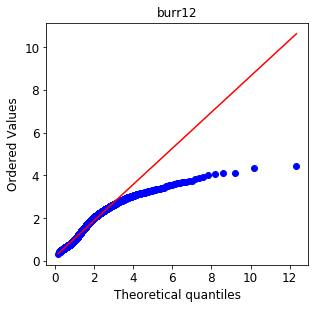

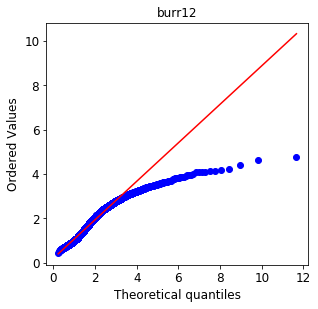

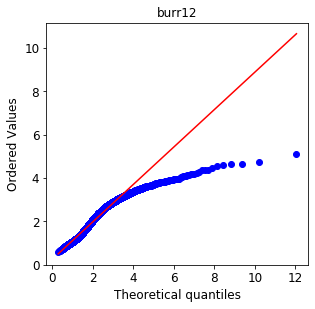

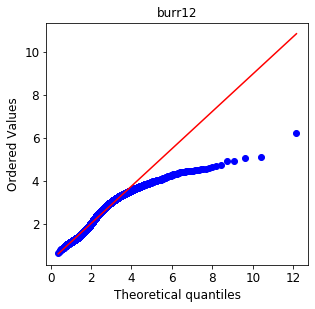

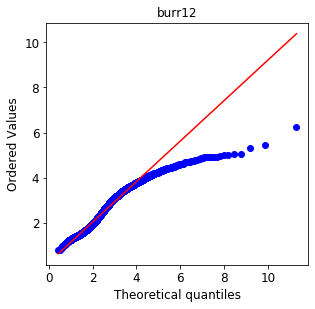

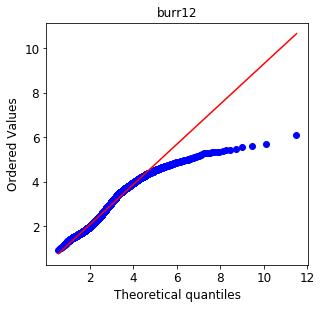

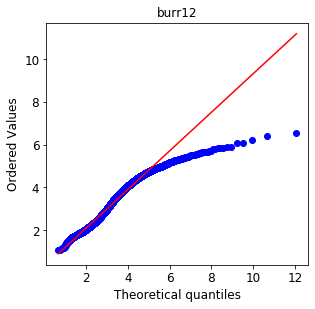

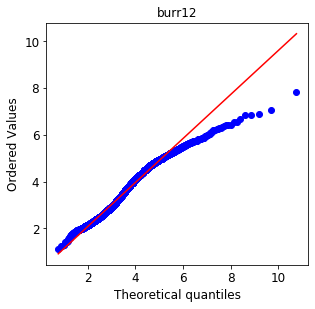

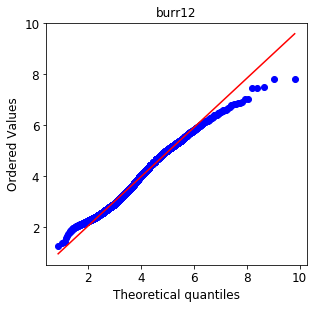

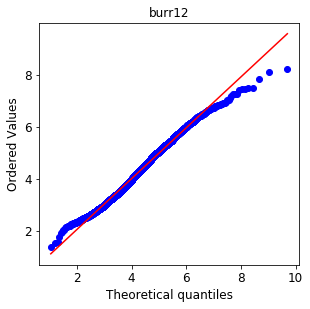

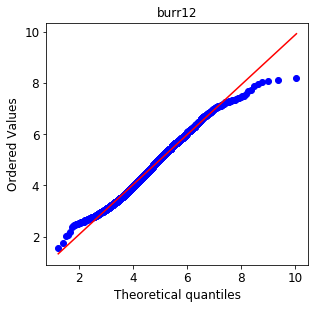

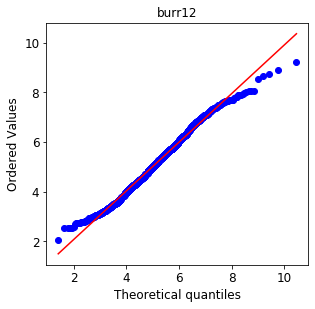

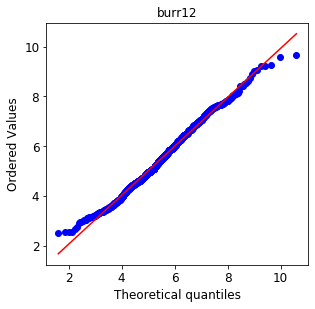

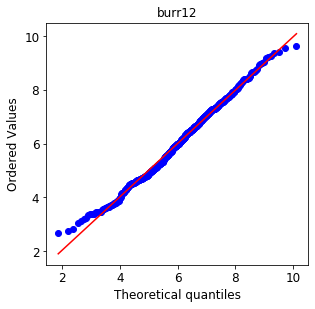

In [145]:
# Plot QQ plot for condY using a given distribution
for condY_pd in self.condY_pd:
    data = condY_pd.data
    df_cur = joint_proba.Univariate.best_fit(
        data, dist_names=['burr12'], dist_config=dist_config, qq_plot=True)

In [5]:
for dist_name in [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]:
    print(f'{dist_name}: {getattr(stats, dist_name).numargs}')

alpha: 1
anglit: 0
arcsine: 0
argus: 1
beta: 2
betaprime: 2
bradford: 1
burr: 2
burr12: 2
cauchy: 0
chi: 1
chi2: 1
cosine: 0
crystalball: 2
dgamma: 1
dweibull: 1
erlang: 1
expon: 0
exponnorm: 1
exponpow: 1
exponweib: 2
f: 2
fatiguelife: 1
fisk: 1
foldcauchy: 1
foldnorm: 1
frechet_l: 1
frechet_r: 1
gamma: 1
gausshyper: 4
genexpon: 3
genextreme: 1
gengamma: 2
genhalflogistic: 1
genlogistic: 1
gennorm: 1
genpareto: 1
gilbrat: 0
gompertz: 1
gumbel_l: 0
gumbel_r: 0
halfcauchy: 0
halfgennorm: 1
halflogistic: 0
halfnorm: 0
hypsecant: 0
invgamma: 1
invgauss: 1
invweibull: 1
johnsonsb: 2
johnsonsu: 2
kappa3: 1
kappa4: 2
ksone: 1
kstwobign: 0
laplace: 0
levy: 0
levy_l: 0
levy_stable: 2
loggamma: 1
logistic: 0
loglaplace: 1
lognorm: 1
lomax: 1
maxwell: 0
mielke: 2
moyal: 0
nakagami: 1
ncf: 3
nct: 2
ncx2: 2
norm: 0
norminvgauss: 2
pareto: 1
pearson3: 1
powerlaw: 1
powerlognorm: 2
powernorm: 1
rayleigh: 0
rdist: 1
recipinvgauss: 1
reciprocal: 2
rice: 1
semicircular: 0
skewnorm: 1
t: 1
trapz: 2
tria